## Stack slightly saturated stars

In [3]:
%load_ext autoreload
%autoreload 2
import os
import copy
import scipy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.stats import sigma_clip
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from unagi import hsc
from unagi import mask
from unagi import plotting
from unagi.task import hsc_cutout, hsc_tricolor, hsc_psf, hsc_check_coverage

# Setup HSC server
s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide', verbose=True)

# Get table list from /Users/jiaxuanli/Research/Packages/unagi/unagi/data/s18a_wide/s18a_wide_tables.fits


In [5]:
from lvhuo.stack import Stack, StackSky, StackStar
from lvhuo.display import (display_single, display_multiple, \
                           draw_circles, draw_rectangles, SEG_CMAP)
from lvhuo.image import query_star, extract_obj

In [6]:
obj_cat = Table.read('./Catalog/s16a_massive_z_0.5_logm_11.4_decals_full_fdfc_bsm_ell.fits', format='fits')
obj = obj_cat[4]
obj_coor = SkyCoord(obj['ra'], obj['dec'], unit='deg')

### Identify which tract/patch this object belongs to, and download this patch

In [7]:
cover_tb = hsc_check_coverage(obj_coor, archive=s18a, verbose=True)
cover_tb[np.where(cover_tb['filter01'] == 'HSC-I')][0]

tract,patch,filter01
int32,bytes64,bytes64
8520,"6,7",HSC-I


In [ ]:
# s18a.download_patch(8520, '6,7', filt='HSC-I');

In [7]:
hdu = fits.open('dr2_s18a_wide_8520_6,7_i.fits')
img = hdu[1].data
hscmask = hdu[2].data
img_hdr = hdu[1].header
w = wcs.WCS(img_hdr)
hdu.close()
psf = hsc_psf(obj_coor, filters='i', archive=s18a)[0].data

# Retrieving coadd PSF model in filter: i


In [8]:
# Query GAIA stars
halosize = 100

star_cat = query_star(img, img_hdr, method='gaia', bright_lim=21)
x, y = w.wcs_world2pix(star_cat['ra'], star_cat['dec'], 0)
fov_mask = (x < img.shape[1] - halosize) & (x > halosize) & (y < img.shape[0] - halosize) & (y > halosize)
star_cat = star_cat[fov_mask]

### Querying Gaia Data ###


In [9]:
# Extract stars from image
objects, segmap = extract_obj(img, b=64, f=3, sigma=4.5, minarea=2,
                              deblend_nthresh=32, deblend_cont=0.005, 
                              sky_subtract=False, show_fig=False, flux_aper=[5, 10])
ra, dec = w.wcs_pix2world(objects['x'], objects['y'], 0)
objects.add_columns([Column(data=ra, name='ra'), Column(data=dec, name='dec')])
# Match two catalogs
temp = match_coordinates_sky(SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg'),
                             SkyCoord(ra=objects['ra'], dec=objects['dec'], unit='deg'))[0]

# Detect 2993 objects


In [171]:
psf_cat = hstack([objects[temp], star_cat], join_type='exact') # here's the final star catalog
psf_cat = psf_cat[psf_cat['fwhm_custom'] < 30] # FWHM selection
psf_cat = psf_cat[(psf_cat['phot_g_mean_mag'] < 18.6) &(psf_cat['phot_g_mean_mag'] > 16.5)]
psf_cat.sort('phot_g_mean_mag')
#psf_cat.reverse()

## Construct a STAR

# Detect 9 objects
# Detect 20 objects
# Global background:  0.005628776270896196


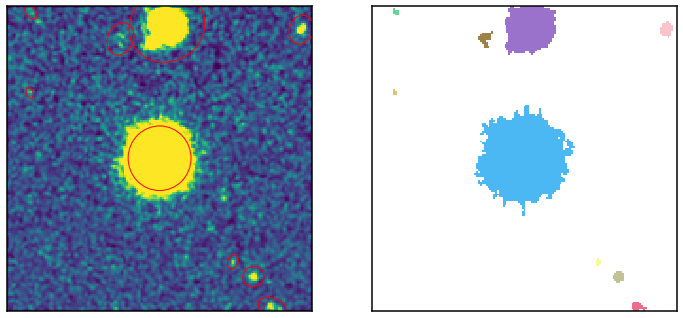

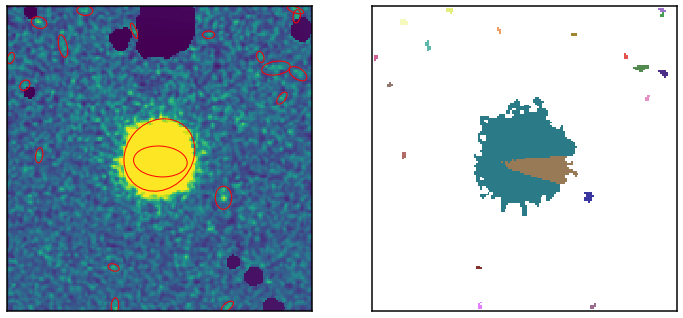

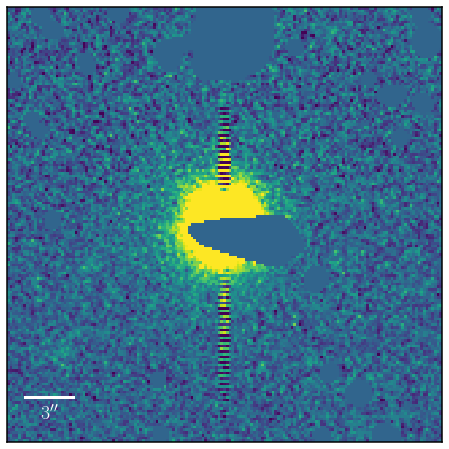

In [176]:
sstar = StackStar(img, img_hdr, psf_cat[3], halosize=80, hscmask=hscmask)
sstar.mask_out_contam(method='sep', show_fig=True)
sstar.centralize()
sstar.sub_bkg()
bitmask = mask.Mask(sstar.hscmask, data_release='s18a')
sstar.display_Stack()

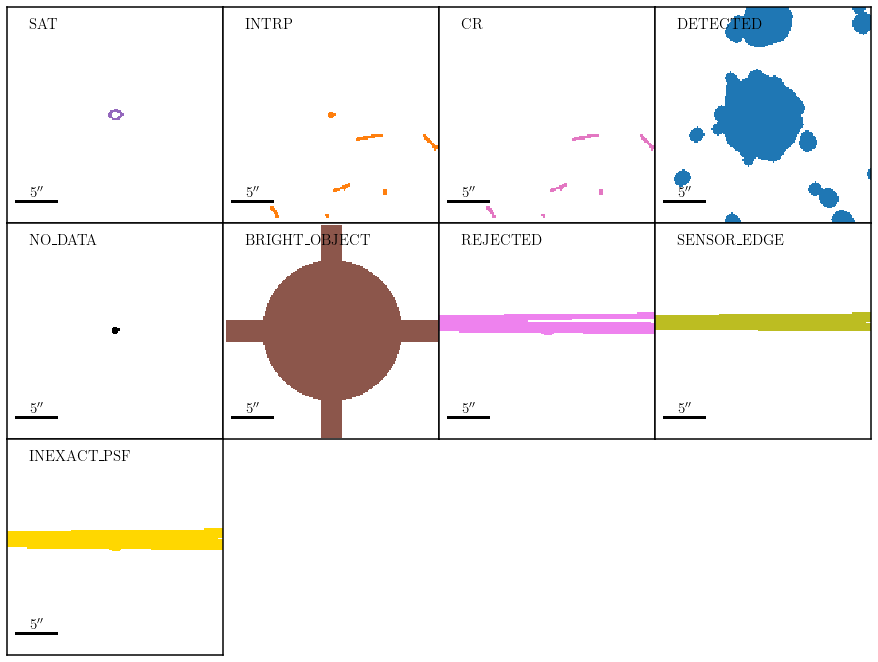

In [177]:
bitmask.show_used();

In [178]:
# Construct and stack `Stars`!!!.
catalog = psf_cat

halosize = 120
size = 2 * halosize + 1
stack_set = np.zeros((len(catalog), size, size))
bad_indices = []
for i, obj in enumerate(catalog):
    try:
        sstar = StackStar(img, img_hdr, obj, halosize=halosize, hscmask=hscmask)
        sstar.mask_out_contam(method='sep', show_fig=False, verbose=False)
        sstar.centralize(method='spline', order=5)
        #sstar.sub_bkg(verbose=False)
        bitmask = mask.Mask(sstar.hscmask, data_release='s18a')
        interp_pix = np.sum(bitmask.extract('INTRP') * (~sstar.mask.astype(bool)))
        sat_pix = np.sum(bitmask.extract('SAT'))
        stack_set[i, :, :] = sstar.get_masked_image(cval=np.nan) / sstar.flux
    except:
        stack_set[i, :, :] = np.ones((size, size)) * 1e9
        bad_indices.append(i)
    del sstar

stack_set = np.delete(stack_set, bad_indices, axis=0)
median_psf = np.nanmedian(stack_set, axis=0)

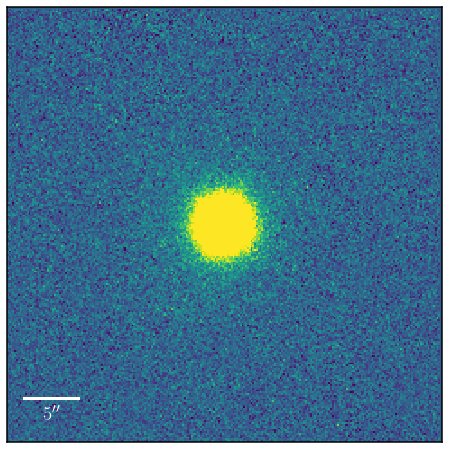

In [179]:
display_single(median_psf);

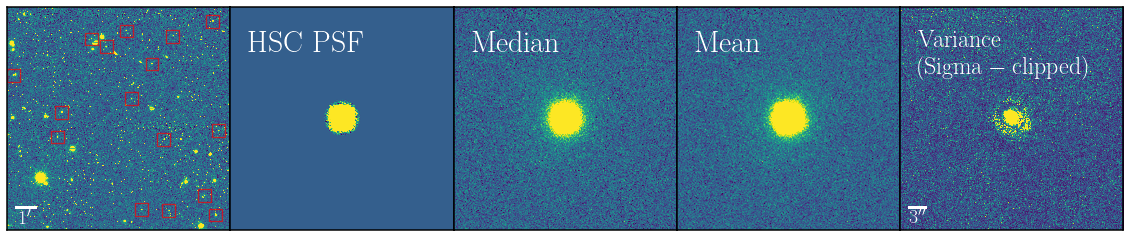

In [180]:
# Plot results
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(20, 8))
# Only show good stars
draw_rectangles(img, catalog[np.setdiff1d(np.arange(0, len(catalog), 1), bad_indices)], 
                ax=ax1, colnames=['x', 'y'],
                header=img_hdr, rectangle_size=[size, size], 
                scale_bar_length=61, scale_bar_y_offset=0.3)

# Show HSC PSF
psf_pad = np.zeros_like(median_psf)
psf_pad[halosize-20:halosize+21, halosize-20:halosize+21] = psf[:, 1:-1]
display_multiple([np.nanmedian(stack_set, axis=0), 
                  np.nanmean(stack_set, axis=0), 
                  psf_pad],
                  ax=[ax3, ax4, ax2], text=['Median', 'Mean', 'HSC\ PSF'], 
                  scale_bar=False)

display_single(np.var(sigma_clip(stack_set, axis=0), axis=0), ax=ax5, 
               scale_bar_length=3, scale_bar_y_offset=0.3,
               add_text='Variance}$\n $\mathrm{(Sigma-clipped)', 
               text_y_offset=0.7, text_fontsize=24)

plt.subplots_adjust(wspace=0.0)
#plt.savefig('./stack_star.png', dpi=150, bbox_inches='tight')

In [181]:
subtract_edge_bkg = True
if subtract_edge_bkg:
    # subtract background of halomodel - made up of residuals of neighboring objects
    edge = np.int(halosize / 5.)
    if edge < 3:
        edge = 3
    uni = np.ones_like(median_psf)
    d = np.sum(median_psf) - np.sum(median_psf[edge: halosize * 2 - edge + 1, 
                                               edge: halosize * 2 - edge + 1])
    area = np.sum(uni) - np.sum(uni[edge: halosize * 2 - edge + 1, 
                                    edge: halosize * 2 - edge + 1])
    d /= area # Now 'd' is the background value per pixel
    median_psf = median_psf - d
# Normalize to 1
median_psf /= np.sum(median_psf)
#from astropy.convolution import Box2DKernel, convolve
#halomodel_sm = convolve(stacked, kernel=Box2DKernel(width=4))

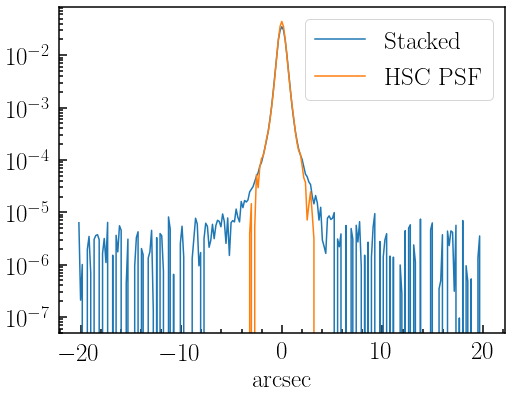

In [182]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(np.arange(-halosize, halosize+1, 1) * 0.168, median_psf[halosize, :], label='$\mathrm{Stacked}$')
plt.plot(np.arange(-20, 21, 1) * 0.168, psf[:, 1:-1][20, :], label='$\mathrm{HSC\ PSF}$')
plt.yscale('log')
plt.xlabel('$\mathrm{arcsec}$')
plt.legend()

In [183]:
from lvhuo.image import save_to_fits
save_to_fits(median_psf, 'median_psf.fits')
save_to_fits(psf, 'hsc_psf.fits')

### Run `ellipse` on them

In [184]:
from lvhuo.display import show_psf_sbp
from lvhuo.image import ellipse_psf_SBP

In [185]:
ell_fix_hsc = ellipse_psf_SBP('hsc_psf.fits',
            None,
            0.168,
            '/Users/jiaxuanli/Research/Dragonfly/CompactObj/compsub/compsub/iraf/macosx/',
            step=0.10,
            n_clip=3,
            low_clip=3.0,
            upp_clip=2.5,
            sma_ini=5, 
            sma_max=halosize,
            verbose=False,
            outPre='hsc_psf')

ell_fix_stack = ellipse_psf_SBP('median_psf.fits',
            None,
            0.168,
            '/Users/jiaxuanli/Research/Dragonfly/CompactObj/compsub/compsub/iraf/macosx/',
            step=0.10,
            n_clip=3,
            low_clip=3.0,
            upp_clip=2.5,
            sma_ini=5, 
            sma_max=halosize,
            verbose=False,
            outPre='stack_psf')

In [186]:
import pickle
with open('ell_fix_stack_nosat.pkl', 'rb') as f:
    ell_fix_stack_unsat = pickle.load(f)

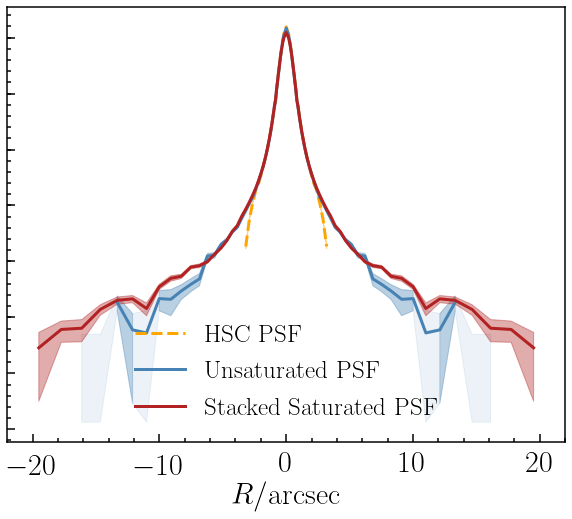

In [187]:
fig, ax = plt.subplots(figsize=(10, 8))
show_psf_sbp(ell_fix_hsc, pixel_scale=0.168, ax=ax, 
        label='HSC\ PSF', linecolor='orange', linestyle='--', labelloc='upper right');
show_psf_sbp(ell_fix_stack_unsat, pixel_scale=0.168, ax=ax, linecolor='steelblue',
        label='Unsaturated\ PSF', labelloc='lower middle');
show_psf_sbp(ell_fix_stack, pixel_scale=0.168, ax=ax, 
        label='Stacked\ Saturated\ PSF', x_max=22, labelloc='lower middle');

ax.invert_yaxis()
plt.savefig('./psf_comparison_saturated.png', bbox_inches='tight')

In [133]:
from pyraf import iraf
from iraf import stsdas
from iraf import analysis
from iraf import isophote

In [134]:
iraf.imdel('./median_psf_bm.fits')
iraf.bmodel(parent='./median_psf.fits', 
            table='./median_psf_ellip_3.bin',
            output='./median_psf_bm.fits', # 'bm' stands for 'bmodel'
            minsma=0.0,
            highar='no',
            backgr = 0.0,
            interp="poly3",
            verbose=True)

Creating rebinned temporary table...

Creating image and filling background value...
Building model...
a0 = 96.          
   0.03  CPU seconds.
   0.00  minutes elapsed.


In [135]:
stacked_bm = fits.open('./median_psf_bm.fits')[0].data

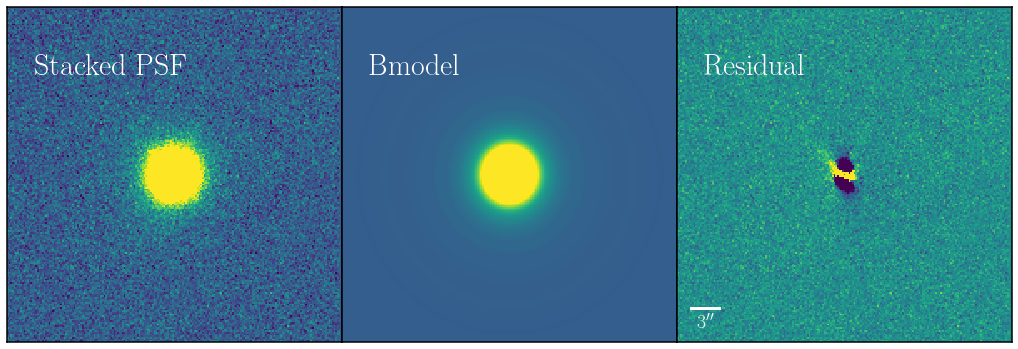

In [136]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 7))
display_multiple([median_psf, stacked_bm], ax=[ax1, ax2], text=['Stacked\ PSF', 'Bmodel'], scale_bar=False)
display_single(median_psf - stacked_bm, ax=ax3, add_text='Residual', scale_bar_length=3, scale_bar_y_offset=0.4)